<a href="https://colab.research.google.com/github/visheshgupta19/Explainable-Techniques-II/blob/main/Explainable_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install grad-cam

In [2]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import os
from google.colab import drive
import requests
from io import BytesIO # Import BytesIO


# GradCAM imports
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, ScoreCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

In [3]:
model = models.resnet50(pretrained=True)
model.eval()

preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
target_layer = model.layer4[-1]

cam_methods = {
    "GradCAM": GradCAM(model=model, target_layers=[target_layer]),
    "GradCAM++": GradCAMPlusPlus(model=model, target_layers=[target_layer]),
    "ScoreCAM": ScoreCAM(model=model, target_layers=[target_layer])
    }

In [5]:
sample_images = {
    'trash':'https://raw.githubusercontent.com/visheshgupta19/Explainable-Deep-Learning/main/images/trash9.jpg',
    'glass':'https://raw.githubusercontent.com/visheshgupta19/Explainable-Deep-Learning/main/images/metal7.jpg',
    'metal':'https://raw.githubusercontent.com/visheshgupta19/Explainable-Deep-Learning/main/images/plastic4.jpg',
    'cardboard':'https://raw.githubusercontent.com/visheshgupta19/Explainable-Deep-Learning/main/images/cardboard3.jpg',
    'plastic':'https://raw.githubusercontent.com/visheshgupta19/Explainable-Deep-Learning/main/images/plastic4.jpg'
}

In [6]:
# drive.mount('/content/drive')
# dataset_folder = '/content/drive/MyDrive/dataset-resized'
# print(os.listdir(dataset_folder))

In [7]:
# class_folders = [f for f in os.listdir(dataset_folder) if os.path.isdir(os.path.join(dataset_folder, f))]

# # Pick one image per class
# sample_images = {}
# for cls in class_folders:
#     folder_path = os.path.join(dataset_folder, cls)
#     images = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png','.jpg','.jpeg'))]
#     if images:
#         sample_images[cls] = os.path.join(folder_path, images[0])  # pick first image

In [8]:
sample_images

{'trash': 'https://raw.githubusercontent.com/visheshgupta19/Explainable-Deep-Learning/main/images/trash9.jpg',
 'glass': 'https://raw.githubusercontent.com/visheshgupta19/Explainable-Deep-Learning/main/images/metal7.jpg',
 'metal': 'https://raw.githubusercontent.com/visheshgupta19/Explainable-Deep-Learning/main/images/plastic4.jpg',
 'cardboard': 'https://raw.githubusercontent.com/visheshgupta19/Explainable-Deep-Learning/main/images/cardboard3.jpg',
 'plastic': 'https://raw.githubusercontent.com/visheshgupta19/Explainable-Deep-Learning/main/images/plastic4.jpg'}

In [9]:
def load_image_local(path):
    try:
        img = Image.open(path).convert("RGB")
        return img
    except:
        print(f"Error loading image: {path}")
        return None

def cam_overlap(cam1, cam2):
    cam1_norm = cam1 / cam1.max()
    cam2_norm = cam2 / cam2.max()
    return np.mean(np.minimum(cam1_norm, cam2_norm))

def apply_cams(img_pil, label, true_class_index=None):
    input_tensor = preprocess(img_pil).unsqueeze(0)

    # Model prediction
    outputs = model(input_tensor)
    probs = F.softmax(outputs, dim=1)
    pred_class = outputs.argmax(dim=1).item()
    pred_prob = probs[0, pred_class].item()

    rgb_img = np.array(img_pil.resize((224,224))) / 255.0

    fig, axes = plt.subplots(1, len(cam_methods)+1, figsize=(18,5))
    axes[0].imshow(img_pil)
    axes[0].set_title(f"Original: {label}\nPredicted: {pred_class} ({pred_prob:.2f})")
    axes[0].axis("off")

    cam_results = {}
    for i, (name, cam) in enumerate(cam_methods.items(), 1):
        if true_class_index is not None:
            target = [ClassifierOutputTarget(true_class_index)]
        else:
            target = None

        grayscale_cam = cam(input_tensor=input_tensor, targets=target)[0, :]
        cam_results[name] = grayscale_cam

        salient_area = (grayscale_cam > 0.5).sum() / grayscale_cam.size
        print(f"{name} salient fraction: {salient_area:.2f}")

        cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
        axes[i].imshow(cam_image)
        axes[i].set_title(name)
        axes[i].axis("off")

        save_path = f"cam_results/{label}_{name}.png"
        cv2.imwrite(save_path, cv2.cvtColor(cam_image, cv2.COLOR_RGB2BGR))

    plt.show()

    overlap_gc_gcpp = cam_overlap(cam_results["GradCAM"], cam_results["GradCAM++"])
    print(f"GradCAM vs GradCAM++ overlap: {overlap_gc_gcpp:.2f}\n")

GradCAM salient fraction: 0.25
GradCAM++ salient fraction: 0.25


100%|██████████| 128/128 [07:49<00:00,  3.67s/it]


ScoreCAM salient fraction: 0.23


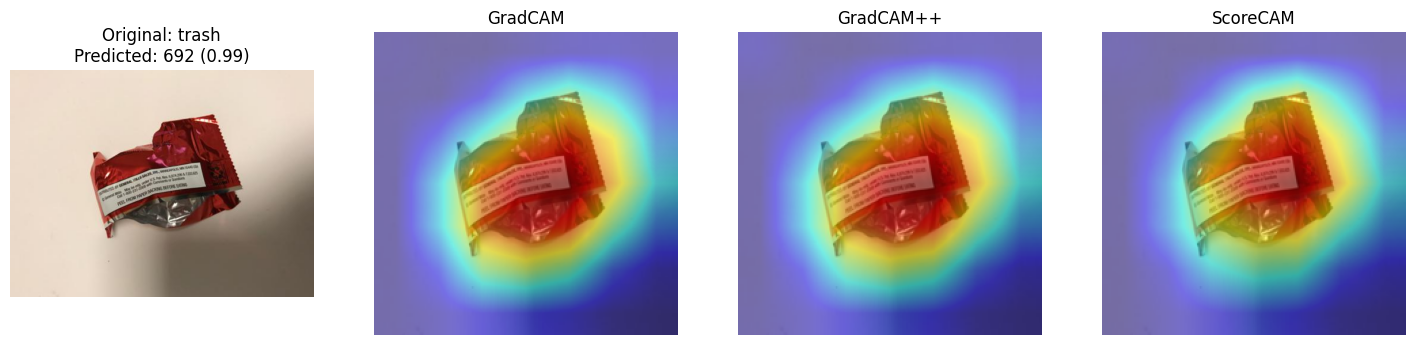

GradCAM vs GradCAM++ overlap: 0.30

GradCAM salient fraction: 0.21
GradCAM++ salient fraction: 0.23


100%|██████████| 128/128 [07:16<00:00,  3.41s/it]


ScoreCAM salient fraction: 0.20


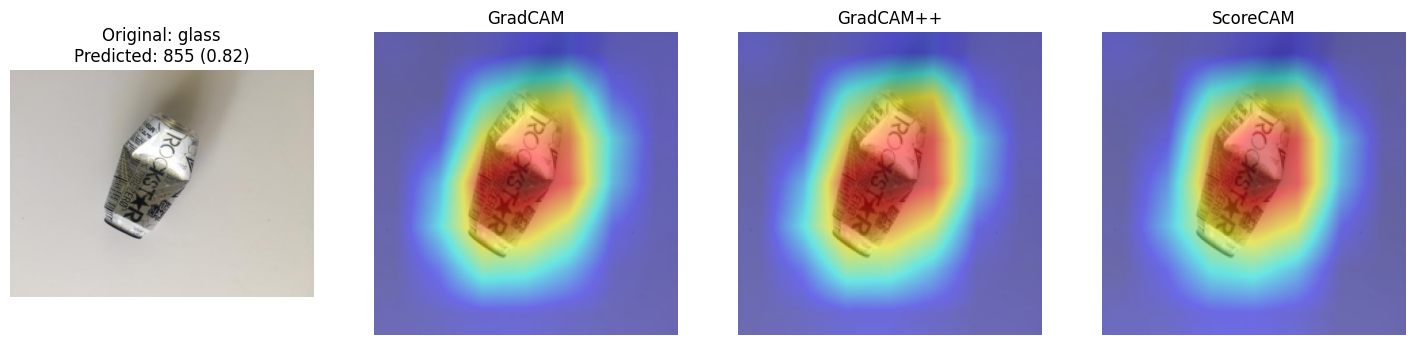

GradCAM vs GradCAM++ overlap: 0.26

GradCAM salient fraction: 0.23
GradCAM++ salient fraction: 0.24


100%|██████████| 128/128 [07:26<00:00,  3.49s/it]


ScoreCAM salient fraction: 0.29


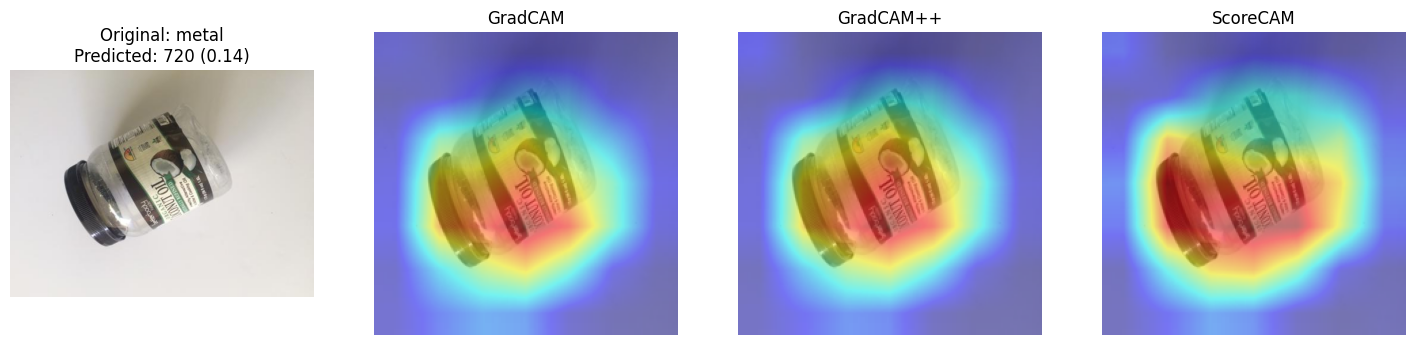

GradCAM vs GradCAM++ overlap: 0.27

GradCAM salient fraction: 0.23
GradCAM++ salient fraction: 0.26


100%|██████████| 128/128 [06:38<00:00,  3.12s/it]


ScoreCAM salient fraction: 0.43


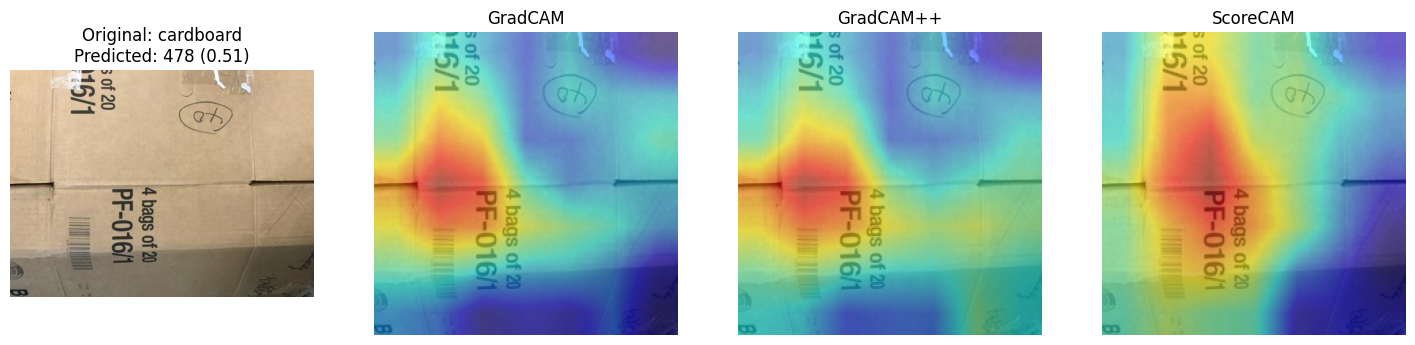

GradCAM vs GradCAM++ overlap: 0.36

GradCAM salient fraction: 0.23
GradCAM++ salient fraction: 0.24


100%|██████████| 128/128 [07:08<00:00,  3.34s/it]


ScoreCAM salient fraction: 0.29


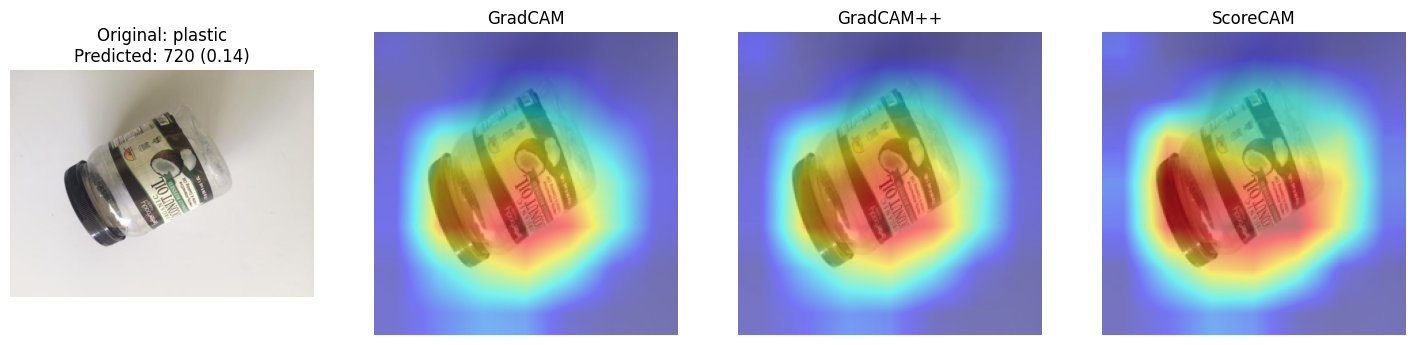

GradCAM vs GradCAM++ overlap: 0.27



In [10]:
for label, url in sample_images.items():
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert("RGB")
    apply_cams(img, label)